### Topic modelling on tweets with BERTweet


In [15]:
#importing required libraries
%pip install nltk emoji==0.6.0
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import re
import os
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
import dataframe_image as dfi
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import TweetTokenizer  #keeps hashtags intact

import torch
from transformers import AutoModel, AutoTokenizer 
from TweetNormalizer import normalizeTweet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49721 sha256=43717421bdc9ae6a676a253261e4a0601fed47150e189bc513be1ad08eda5312
  Stored in directory: /Users/alicjadorobis/Library/Caches/pip/wheels/43/3d/82/e7baffa5e86346c6178d7750dba6e8ef063282a37fc563f8f8
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'TweetNormalizer'

Running the topic modelling on the 3000 tweets as a 100 was too little.

In [3]:

# loading the data into a dataframe
df = pd.read_excel('../../data/test/3000_random_rows_24_07_2020.xlsx')
display(df.head())

created_at_fuzzy state_likely_tweeted_from  \
0  2020-07-23T21:55:47Z             West Virginia   
1  2020-07-24T21:33:27Z                     Texas   
2  2020-07-19T18:38:32Z                    Nevada   
3  2020-07-25T00:29:24Z                  Colorado   
4  2020-07-24T10:22:45Z                 Minnesota   

                                                text               source  \
0  Pelosi\n\nHer latest line? That Pres. Trump wi...   Twitter for iPhone   
1  @okkels @JennaEllisEsq We're aware of how detr...  Twitter for Android   
2  "Atlantic writer &amp; former ESPN talker Jeme...      Twitter Web App   
3  HE BREAKS THE LAW AND NOTHING IS DONE BY EITHE...  Twitter for Android   
4  @DorMouseSez @Teri_A_Adams The problem I have ...      Twitter Web App   

   display_text_width lang  favorite_count  retweet_count  is_quote  \
0                 274   en               3              2     False   
1                 144   en               0              0     False   
2                 291   en               0              0     False   
3                 276   en               0              0     False   
4                 276   en               1              1     False   

   followers_count  friends_count  listed_count  statuses_count  \
0              607            460            10           66222   
1                6             37             0             345   
2               11             22             0            2751   
3              324            324             1            2446   
4               90            207             0            1199   

   favourites_count  
0             18148  
1               349  
2               567  
3               897  
4              3432

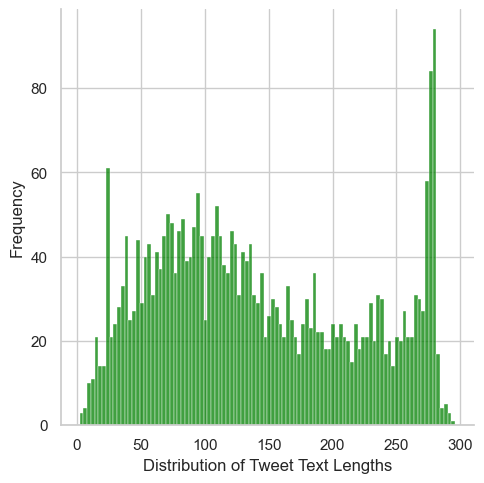

In [4]:
#adding an extra column as this is the columsn that will appear in the dataset we gave to LLM, we can of course adapt this 
# just depends which analysis we will be doing first 

df['cleaned_text'] = df['text']


# creating a new column containing the length of each headline text that is larger than 0
non_empty_lengths = df[(df['cleaned_text'].notnull()) & (df['display_text_width'] > 0)]['display_text_width']
# visualising the length distribution 

sns.set(rc={'figure.figsize':(14,11)})
sns.set(style="whitegrid")
sns.displot(non_empty_lengths, kde=False, color='green', bins=100)


plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Distribution of Tweet Text Lengths', fontsize=12)
plt.grid(True)


plt.show()

## Pre-processing the text

In [5]:
#removing line spacing and 'at' symbols
df['cleaned_text'] = df['cleaned_text'].replace('\n',' ', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace('\xa0',' ', regex=True)


In [6]:
import re

def remove_links(text):
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    if isinstance(text, str):
        # Replace URLs with an empty string
        return re.sub(url_pattern, '', text)
    elif isinstance(text, (int, float)):
        # Convert non-string types to string and remove links
        return re.sub(url_pattern, '', str(text))
    else:
        return text  # Return as is if not a string, int, or float

# Example usage:
# Apply remove_links function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_links)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Pelosi  Her latest line? That Pres. Trump will...
1       @okkels @JennaEllisEsq We're aware of how detr...
2       "Atlantic writer &amp; former ESPN talker Jeme...
3       HE BREAKS THE LAW AND NOTHING IS DONE BY EITHE...
4       @DorMouseSez @Teri_A_Adams The problem I have ...
                              ...                        
2995    @AdamParkhomenko I try to avoid reading Trump'...
2996    @WalshFreedom @Ooter1 The GOP is not a conserv...
2997    President Trump's Anti-Censorship Bill Is Abou...
2998    @brianschatz It’s BS. Trump is panicking at hi...
2999    Trump is cognitive alright but not in a good way 
Name: cleaned_text, Length: 3000, dtype: object


In [7]:

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                      
    return re.sub(emoj, '', str(data))  # Convert data to string before removing emojis

# Apply remove_emojis function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_emojis)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Pelosi  Her latest line? That Pres. Trump will...
1       @okkels @JennaEllisEsq We're aware of how detr...
2       "Atlantic writer &amp; former ESPN talker Jeme...
3       HE BREAKS THE LAW AND NOTHING IS DONE BY EITHE...
4       @DorMouseSez @Teri_A_Adams The problem I have ...
                              ...                        
2995    @AdamParkhomenko I try to avoid reading Trump'...
2996    @WalshFreedom @Ooter1 The GOP is not a conserv...
2997    President Trump's Anti-Censorship Bill Is Abou...
2998    @brianschatz It’s BS. Trump is panicking at hi...
2999    Trump is cognitive alright but not in a good way 
Name: cleaned_text, Length: 3000, dtype: object


In [8]:
import re

def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    else:
        return text

# Apply remove_numbers function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)



0       Pelosi  Her latest line? That Pres. Trump will...
1       @okkels @JennaEllisEsq We're aware of how detr...
2       "Atlantic writer &amp; former ESPN talker Jeme...
3       HE BREAKS THE LAW AND NOTHING IS DONE BY EITHE...
4       @DorMouseSez @Teri_A_Adams The problem I have ...
                              ...                        
2995    @AdamParkhomenko I try to avoid reading Trump'...
2996    @WalshFreedom @Ooter The GOP is not a conserva...
2997    President Trump's Anti-Censorship Bill Is Abou...
2998    @brianschatz It’s BS. Trump is panicking at hi...
2999    Trump is cognitive alright but not in a good way 
Name: cleaned_text, Length: 3000, dtype: object


In [150]:
### question: do we want to remove all twitter handles ?


In [9]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    elif isinstance(text, (int, float)):
        return str(text).translate(str.maketrans('', '', string.punctuation))
    else:
        return text  # Return as is if not a string, int, or float

# Apply remove_punctuation function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Pelosi  Her latest line That Pres Trump will l...
1       okkels JennaEllisEsq Were aware of how detrime...
2       Atlantic writer amp former ESPN talker Jemele ...
3       HE BREAKS THE LAW AND NOTHING IS DONE BY EITHE...
4       DorMouseSez TeriAAdams The problem I have is t...
                              ...                        
2995    AdamParkhomenko I try to avoid reading Trumps ...
2996    WalshFreedom Ooter The GOP is not a conservati...
2997    President Trumps AntiCensorship Bill Is About ...
2998    brianschatz It’s BS Trump is panicking at his ...
2999    Trump is cognitive alright but not in a good way 
Name: cleaned_text, Length: 3000, dtype: object


In [148]:
# manually replacing synonyms and words
'''
df['review_text_english'] = df['review_text_english'].str.replace(r'\b(?:bicycle|bikes)\b', 'bike', case=False, regex=True)

df['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)
'''

"\ndf['review_text_english'] = df['review_text_english'].str.replace(r'\x08(?:bicycle|bikes)\x08', 'bike', case=False, regex=True)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)\n"

1. case-normalization


In [10]:
text_list = df['cleaned_text'].tolist()

# case normalization function
def case_normalization(text):
    return text.lower()

# apply case normalization to each element of the text list
normalized_text_list = [case_normalization(word) for word in text_list]

print(normalized_text_list)


['pelosi  her latest line that pres trump will lose the election in november and be forced out of the white house she said during an msnbc interview on mon that she believes trump will refuse to leave and that she endorses use of chemicals or force the pres out of the wh', 'okkels jennaellisesq were aware of how detrimental democrats have been to us president trump is reversing the damage they did and yall mad you can kiss my bum ', 'atlantic writer amp former espn talker jemele hill says that each amp every trump voter is a racist  no no jemele im a trump voter im not a racist you on the other hand are a racist  a moron amp havent the sense god gave a goose how did you ever get a salary paying job', 'he breaks the law and nothing is done by either side of congress  trump administration tries to block release of a documentary that shows ice agents illegally breaking into home eager to arrest immigrants without criminal records  via businessinsider', 'dormousesez teriaadams the problem 

## Visualisation of word distribution

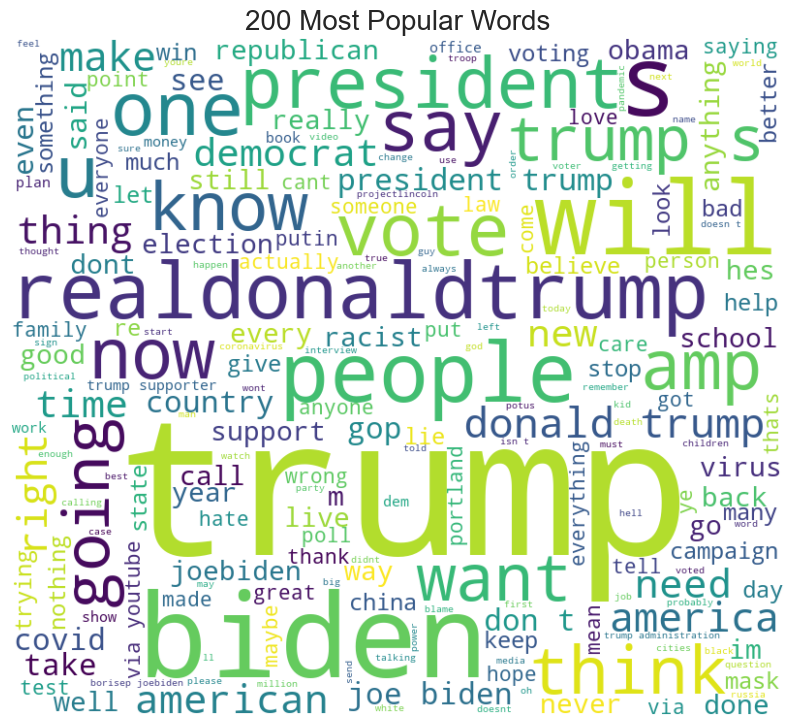

In [11]:
# words visualisation with a wordcloud
concatenated_text = ' '.join(normalized_text_list)
# generating
wordcloud = WordCloud(width=800, height=700, max_words=200, background_color='white').generate(concatenated_text)

# plotting the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('200 Most Popular Words', size= 20)
plt.show()

## Further pre-processing for topic modelling

2. tokenization

In [126]:
def tokenization(text):
    return text.split()
    
tokenized_text_list = [tokenization(word) for word in normalized_text_list]

print(tokenized_text_list)

[['pelosi', 'her', 'latest', 'line', 'that', 'pres', 'trump', 'will', 'lose', 'the', 'election', 'in', 'november', 'and', 'be', 'forced', 'out', 'of', 'the', 'white', 'house', 'she', 'said', 'during', 'an', 'msnbc', 'interview', 'on', 'mon', 'that', 'she', 'believes', 'trump', 'will', 'refuse', 'to', 'leave', 'and', 'that', 'she', 'endorses', 'use', 'of', 'chemicals', 'or', 'force', 'the', 'pres', 'out', 'of', 'the', 'wh'], ['okkels', 'jennaellisesq', 'were', 'aware', 'of', 'how', 'detrimental', 'democrats', 'have', 'been', 'to', 'us', 'president', 'trump', 'is', 'reversing', 'the', 'damage', 'they', 'did', 'and', 'yall', 'mad', 'you', 'can', 'kiss', 'my', 'bum', 'httpstcotglhmfkd'], ['atlantic', 'writer', 'amp', 'former', 'espn', 'talker', 'jemele', 'hill', 'says', 'that', 'each', 'amp', 'every', 'trump', 'voter', 'is', 'a', 'racist', 'no', 'no', 'jemele', 'im', 'a', 'trump', 'voter', 'im', 'not', 'a', 'racist', 'you', 'on', 'the', 'other', 'hand', 'are', 'a', 'racist', 'a', 'moron', 

3. stopwords removal 

In [127]:

custom_stopwords = ['€']

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    return [token for token in tokens if token not in stop_words]

tokens = [remove_stopwords(word) for word in tokenized_text_list]
print(tokens)

[['pelosi', 'latest', 'line', 'pres', 'trump', 'lose', 'election', 'november', 'forced', 'white', 'house', 'said', 'msnbc', 'interview', 'mon', 'believes', 'trump', 'refuse', 'leave', 'endorses', 'use', 'chemicals', 'force', 'pres', 'wh'], ['okkels', 'jennaellisesq', 'aware', 'detrimental', 'democrats', 'us', 'president', 'trump', 'reversing', 'damage', 'yall', 'mad', 'kiss', 'bum', 'httpstcotglhmfkd'], ['atlantic', 'writer', 'amp', 'former', 'espn', 'talker', 'jemele', 'hill', 'says', 'amp', 'every', 'trump', 'voter', 'racist', 'jemele', 'im', 'trump', 'voter', 'im', 'racist', 'hand', 'racist', 'moron', 'amp', 'havent', 'sense', 'god', 'gave', 'goose', 'ever', 'get', 'salary', 'paying', 'job'], ['breaks', 'law', 'nothing', 'done', 'either', 'side', 'congress', 'trump', 'administration', 'tries', 'block', 'release', 'documentary', 'shows', 'ice', 'agents', 'illegally', 'breaking', 'home', 'eager', 'arrest', 'immigrants', 'without', 'criminal', 'records', 'httpstcoynbltw', 'via', 'busin

In [128]:
# transforming into a string to create a model
tokens = [str(token) for token in tokens]
print(tokens)
tokens = [string.strip("'") for string in tokens if string.strip("[]").strip("'")]

["['pelosi', 'latest', 'line', 'pres', 'trump', 'lose', 'election', 'november', 'forced', 'white', 'house', 'said', 'msnbc', 'interview', 'mon', 'believes', 'trump', 'refuse', 'leave', 'endorses', 'use', 'chemicals', 'force', 'pres', 'wh']", "['okkels', 'jennaellisesq', 'aware', 'detrimental', 'democrats', 'us', 'president', 'trump', 'reversing', 'damage', 'yall', 'mad', 'kiss', 'bum', 'httpstcotglhmfkd']", "['atlantic', 'writer', 'amp', 'former', 'espn', 'talker', 'jemele', 'hill', 'says', 'amp', 'every', 'trump', 'voter', 'racist', 'jemele', 'im', 'trump', 'voter', 'im', 'racist', 'hand', 'racist', 'moron', 'amp', 'havent', 'sense', 'god', 'gave', 'goose', 'ever', 'get', 'salary', 'paying', 'job']", "['breaks', 'law', 'nothing', 'done', 'either', 'side', 'congress', 'trump', 'administration', 'tries', 'block', 'release', 'documentary', 'shows', 'ice', 'agents', 'illegally', 'breaking', 'home', 'eager', 'arrest', 'immigrants', 'without', 'criminal', 'records', 'httpstcoynbltw', 'via',

5. stemming and lemmatization

In [129]:

# initialising stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# stemming
stemmed_words = [stemmer.stem(token) for token in tokens]

# lemmatization
lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]


print("Stemmed Tokens:", stemmed_words)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

Stemmed Tokens: ["['pelosi', 'latest', 'line', 'pres', 'trump', 'lose', 'election', 'november', 'forced', 'white', 'house', 'said', 'msnbc', 'interview', 'mon', 'believes', 'trump', 'refuse', 'leave', 'endorses', 'use', 'chemicals', 'force', 'pres', 'wh']", "['okkels', 'jennaellisesq', 'aware', 'detrimental', 'democrats', 'us', 'president', 'trump', 'reversing', 'damage', 'yall', 'mad', 'kiss', 'bum', 'httpstcotglhmfkd']", "['atlantic', 'writer', 'amp', 'former', 'espn', 'talker', 'jemele', 'hill', 'says', 'amp', 'every', 'trump', 'voter', 'racist', 'jemele', 'im', 'trump', 'voter', 'im', 'racist', 'hand', 'racist', 'moron', 'amp', 'havent', 'sense', 'god', 'gave', 'goose', 'ever', 'get', 'salary', 'paying', 'job']", "['breaks', 'law', 'nothing', 'done', 'either', 'side', 'congress', 'trump', 'administration', 'tries', 'block', 'release', 'documentary', 'shows', 'ice', 'agents', 'illegally', 'breaking', 'home', 'eager', 'arrest', 'immigrants', 'without', 'criminal', 'records', 'httpstc

# Analysis

1. Bag of words 

In [130]:
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

Counter({"['pelosi', 'latest', 'line', 'pres', 'trump', 'lose', 'election', 'november', 'forced', 'white', 'house', 'said', 'msnbc', 'interview', 'mon', 'believes', 'trump', 'refuse', 'leave', 'endorses', 'use', 'chemicals', 'force', 'pres', 'wh']": 1,
         "['okkels', 'jennaellisesq', 'aware', 'detrimental', 'democrats', 'us', 'president', 'trump', 'reversing', 'damage', 'yall', 'mad', 'kiss', 'bum', 'httpstcotglhmfkd']": 1,
         "['atlantic', 'writer', 'amp', 'former', 'espn', 'talker', 'jemele', 'hill', 'says', 'amp', 'every', 'trump', 'voter', 'racist', 'jemele', 'im', 'trump', 'voter', 'im', 'racist', 'hand', 'racist', 'moron', 'amp', 'havent', 'sense', 'god', 'gave', 'goose', 'ever', 'get', 'salary', 'paying', 'job']": 1,
         "['breaks', 'law', 'nothing', 'done', 'either', 'side', 'congress', 'trump', 'administration', 'tries', 'block', 'release', 'documentary', 'shows', 'ice', 'agents', 'illegally', 'breaking', 'home', 'eager', 'arrest', 'immigrants', 'without', 'cr

# Modelling

In [131]:
# preparing embeddings
sentence_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
embeddings = sentence_model.encode(tokens, show_progress_bar=False)

# training BERTopic
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', nr_topics=10) # min_topic_size
review_topics, _ = model.fit_transform(tokens)

# running the visualization with the original embeddings
model.visualize_documents(tokens, embeddings=embeddings)

# reducing dimensionality of embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)



2024-03-24 11:16:08,365 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [00:05<00:00, 16.85it/s]
2024-03-24 11:16:16,031 - BERTopic - Embedding - Completed ✓
2024-03-24 11:16:16,032 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 11:16:24,746 - BERTopic - Dimensionality - Completed ✓
2024-03-24 11:16:24,748 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 11:16:24,891 - BERTopic - Cluster - Completed ✓
2024-03-24 11:16:24,891 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-24 11:16:25,006 - BERTopic - Representation - Completed ✓
2024-03-24 11:16:25,007 - BERTopic - Topic reduction - Reducing number of topics
2024-03-24 11:16:25,105 - BERTopic - Topic reduction - Reduced number of topics from 35 to 10


In [132]:
#appending the dataset with a coolumn "topic"
topics, _ = model.fit_transform(df['cleaned_text'])
# Assign topic labels to each tweet in the dataset
df['topic_label'] = topics

# Save the DataFrame with the new column
df.to_csv('dataset_with_topic_labels.csv', index=False)

2024-03-24 11:16:42,580 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [00:10<00:00,  8.69it/s]
2024-03-24 11:16:53,481 - BERTopic - Embedding - Completed ✓
2024-03-24 11:16:53,482 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 11:17:01,546 - BERTopic - Dimensionality - Completed ✓
2024-03-24 11:17:01,547 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 11:17:01,673 - BERTopic - Cluster - Completed ✓
2024-03-24 11:17:01,674 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-24 11:17:01,799 - BERTopic - Representation - Completed ✓
2024-03-24 11:17:01,800 - BERTopic - Topic reduction - Reducing number of topics
2024-03-24 11:17:01,905 - BERTopic - Topic reduction - Reduced number of topics from 37 to 10


In [133]:


# get topic vectors
topic_vectors = model.transform(tokens)

# compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_vectors)

# Display the similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Batches: 100%|██████████| 94/94 [00:05<00:00, 18.26it/s]
2024-03-24 11:17:07,183 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-03-24 11:17:21,899 - BERTopic - Dimensionality - Completed ✓
2024-03-24 11:17:21,900 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-03-24 11:17:22,095 - BERTopic - Cluster - Completed ✓


Cosine Similarity Matrix:
[[1.         0.31302279]
 [0.31302279 1.        ]]


In [134]:
model.visualize_documents(tokens, reduced_embeddings=reduced_embeddings)

### Topic Extraction and Representation

In [135]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

frequency = model.get_topic_info()
print("Number of topics: {}".format( len(frequency)))
display(frequency)
dfi.export(frequency, 'dataframe_topics.png')

Number of topics: 10


Topic  Count                                        Name  \
0     -1   1201                         -1_trump_the_to_and   
1      0   1219                          0_trump_the_to_and   
2      1    373                          1_biden_to_the_and   
3      2     66        2_realdonaldtrump_whitehouse_is_that   
4      3     37  3_gorillastyle_vickie_dennisabm_sandycedar   
5      4     32                             4_de_en_het_dat   
6      5     27                  5_cohen_judge_book_michael   
7      6     19                6_pitch_first_throw_baseball   
8      7     13                    7_never_the_trump_stated   
9      8     13         8_drug_executive_prescription_lower   

                                      Representation  \
0  [trump, the, to, and, of, is, in, you, that, for]   
1   [trump, the, to, and, is, of, in, it, you, that]   
2  [biden, to, the, and, is, joebiden, joe, you, ...   
3  [realdonaldtrump, whitehouse, is, that, this, ...   
4  [gorillastyle, vickie, dennisabm, sandycedar, ...   
5  [de, en, het, dat, que, van, inte, een, niet, ...   
6  [cohen, judge, book, michael, prison, orders, ...   
7  [pitch, first, throw, baseball, out, trump, pl...   
8  [never, the, trump, stated, hoax, it, truth, t...   
9  [drug, executive, prescription, lower, orders,...   

                                 Representative_Docs  
0  [MSNBC The arrogance that these thugs have to ...  
1  [WWGWGAWORLWIDE OUR WORLD IS SO CORRUPT ARE U ...  
2  [Joe Biden Is New President, Heard part of the...  
3  [NECN Anybody look into this yet  The playbook...  
4  [Vs wrecksreed MenVoters kristyshl sandycedar ...  
5  [Si usted es tan  que lo cree  pobrecito But i...  
6  [ trump tried to keep Cohen in prison because ...  
7  [TaylorRMarshall Has it Trump was going to thr...  
8  [Mary Trump Hes never been held accountable An...  
9  [Report Trump To Sign Executive Orders Aimed A...

-1 refers to all outliers and should typically be ignored. The most frequent topic that was generated, topic 0:

In [136]:
model.get_topic(0)

[('trump', 0.056032253739926444),
 ('the', 0.0508484455722293),
 ('to', 0.044372544447673544),
 ('and', 0.03541633178283456),
 ('is', 0.0353549714481607),
 ('of', 0.031061804261188503),
 ('in', 0.02799065432356019),
 ('it', 0.026613916228338697),
 ('you', 0.025574102106043266),
 ('that', 0.024976379255269632)]

In [137]:
model.get_document_info(tokens)

Document  Topic  \
0     ['pelosi', 'latest', 'line', 'pres', 'trump', ...     -1   
1     ['okkels', 'jennaellisesq', 'aware', 'detrimen...     -1   
2     ['atlantic', 'writer', 'amp', 'former', 'espn'...      0   
3     ['breaks', 'law', 'nothing', 'done', 'either',...     -1   
4     ['dormousesez', 'teriaadams', 'problem', 'gop'...     -1   
...                                                 ...    ...   
2995  ['adamparkhomenko', 'try', 'avoid', 'reading',...      0   
2996  ['walshfreedom', 'ooter', 'gop', 'conservative...     -1   
2997  ['president', 'trumps', 'anticensorship', 'bil...      0   
2998  ['brianschatz', 'it’s', 'bs', 'trump', 'panick...      0   
2999  ['trump', 'cognitive', 'alright', 'good', 'way...     -1   

                     Name                                     Representation  \
0     -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   
1     -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   
2      0_trump_the_to_and   [trump, the, to, and, is, of, in, it, you, that]   
3     -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   
4     -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   
...                   ...                                                ...   
2995   0_trump_the_to_and   [trump, the, to, and, is, of, in, it, you, that]   
2996  -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   
2997   0_trump_the_to_and   [trump, the, to, and, is, of, in, it, you, that]   
2998   0_trump_the_to_and   [trump, the, to, and, is, of, in, it, you, that]   
2999  -1_trump_the_to_and  [trump, the, to, and, of, is, in, you, that, for]   

                                    Representative_Docs  \
0     [MSNBC The arrogance that these thugs have to ...   
1     [MSNBC The arrogance that these thugs have to ...   
2     [WWGWGAWORLWIDE OUR WORLD IS SO CORRUPT ARE U ...   
3     [MSNBC The arrogance that these thugs have to ...   
4     [MSNBC The arrogance that these thugs have to ...   
...                                                 ...   
2995  [WWGWGAWORLWIDE OUR WORLD IS SO CORRUPT ARE U ...   
2996  [MSNBC The arrogance that these thugs have to ...   
2997  [WWGWGAWORLWIDE OUR WORLD IS SO CORRUPT ARE U ...   
2998  [WWGWGAWORLWIDE OUR WORLD IS SO CORRUPT ARE U ...   
2999  [MSNBC The arrogance that these thugs have to ...   

                                            Top_n_words  Probability  \
0     trump - the - to - and - of - is - in - you - ...     0.000000   
1     trump - the - to - and - of - is - in - you - ...     0.000000   
2     trump - the - to - and - is - of - in - it - y...     0.411750   
3     trump - the - to - and - of - is - in - you - ...     0.000000   
4     trump - the - to - and - of - is - in - you - ...     0.000000   
...                                                 ...          ...   
2995  trump - the - to - and - is - of - in - it - y...     0.881753   
2996  trump - the - to - and - of - is - in - you - ...     0.000000   
2997  trump - the - to - and - is - of - in - it - y...     0.774468   
2998  trump - the - to - and - is - of - in - it - y...     1.000000   
2999  trump - the - to - and - of - is - in - you - ...     0.000000   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
2995                    False  
2996                    False  
2997                    False  
2998                    False  
2999                    False  

[3000 rows x 8 columns]

Top terms and c-TF-IDF scores

In [138]:
a_topic = frequency.iloc[1]["Topic"] # selecting the 1st topic
model.get_topic(a_topic) # showing the words and their c-TF-IDF scores

[('trump', 0.056032253739926444),
 ('the', 0.0508484455722293),
 ('to', 0.044372544447673544),
 ('and', 0.03541633178283456),
 ('is', 0.0353549714481607),
 ('of', 0.031061804261188503),
 ('in', 0.02799065432356019),
 ('it', 0.026613916228338697),
 ('you', 0.025574102106043266),
 ('that', 0.024976379255269632)]

### Topic visualisation


In [139]:

model.visualize_barchart(top_n_topics=17, n_words= 10, width = 300, height = 350)

In [140]:
model.visualize_topics()

In [141]:
# Calculate the percentage representation of topics

your_docs = tokens
topic_counts = Counter(review_topics)
total_documents = len(your_docs)
topic_percentages = {topic: count / total_documents * 100 for topic, count in topic_counts.items()}
topic_percentages = {topic: round(count / total_documents * 100, 2) for topic, count in topic_counts.items()}

# Create a DataFrame from the topic percentages
df_topic_percentages = pd.DataFrame(list(topic_percentages.items()), columns=['Topic', 'Percentage of documents in a topic'])
df_topic_percentages = df_topic_percentages.sort_values(by='Topic', ascending=True)
df_topic_percentages['Percentage of documents in a topic'] = df_topic_percentages['Percentage of documents in a topic'].astype(str) + '%'

# Display the DataFrame
display(df_topic_percentages)

dfi.export(df_topic_percentages, 'dataframe_topics%.png')

Topic Percentage of documents in a topic
1     -1                              54.3%
0      0                              34.5%
7      1                              4.37%
5      2                              1.93%
4      3                               1.2%
8      4                               1.2%
2      5                              0.83%
9      6                               0.7%
3      7                               0.5%
6      8                              0.47%

In [142]:
model.visualize_hierarchy(top_n_topics=30)

In [143]:
similar_topics, similarity = model.find_topics("politics", top_n = 3)
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('trump', 0.04957753212891777), ('the', 0.04836832402821246), ('to', 0.040813023087473595), ('and', 0.03520415023926132), ('of', 0.03362889464035228), ('is', 0.03245964460417863), ('in', 0.028692871811873404), ('you', 0.026184888879553343), ('that', 0.0257123423987681), ('for', 0.02304396047641468)]
Similarity Score: 0.3718113070207757


In [144]:
#saving the model
model.save("bert_best_model_tweets")

# loading the serialised model
my_best_model = BERTopic.load("bert_best_model_tweets")
my_best_model

2024-03-24 11:17:29,803 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
